In [1]:
import os
os.chdir('/homes/pr450/repos/research_projects/sampling_ddpm')

os.environ["CUDA_VISIBLE_DEVICES"]="1"

import torch

from tqdm import tqdm
from torch import Tensor as _T

from ddpm.model.main.multiepoch import MultiPreparatoryHVAEReverseProcess
from ddpm.tasks.main.base import DiffusionTask

from ddpm.utils.loading import generate_model_and_task_from_args_path_multiepoch
from purias_utils.util.logging import configure_logging_paths
from purias_utils.util.plotting import standard_swap_model_simplex_plots
from purias_utils.error_modelling_torus.non_parametric_error_model.setup_utils import setup_model_whole, WorkingMemoryFullSwapModel

from purias_utils.multiitem_working_memory.util.circle_utils import rectify_angles, polar2cart

from sklearn.decomposition import PCA

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.cm as cmx
import matplotlib.colors as colors

from analysis.new_analysis.plane_alignment_utils import *


import numpy as np
from scipy.spatial.distance import pdist



base_dir_name = 'hvae_with_dendritic_20250410'
run_name = 'run_d_control_a5_0'
device = 'cuda'

_, task, ddpm_model, _, _ = generate_model_and_task_from_args_path_multiepoch(f'/homes/pr450/repos/research_projects/sampling_ddpm/results_link_sampler/{base_dir_name}/{run_name}/args.yaml', device)
ddpm_model.load_state_dict(torch.load(f'/homes/pr450/repos/research_projects/sampling_ddpm/results_link_sampler/{base_dir_name}/{run_name}/state.mdl', weights_only=True))
ddpm_model: MultiPreparatoryHVAEReverseProcess


for n, parameter in ddpm_model.named_parameters():
    parameter.required_grad = False


In [2]:
def generate_example_sample_sets(
    rnn: WorkingMemoryFullSwapModel, 
    task: DiffusionTask, 
    distractor_probe: float,
    distractor_report: float, 
    generative_noise_factor: float,
    num_samples: int = 512
    ) -> _T:
        
        probe_features = torch.tensor([[0.0, distractor_probe]])
        report_features = torch.tensor([[0.0, distractor_report]])

        override_stimulus_features = {
            'probe_features': probe_features,
            'report_features': report_features,
        }
        override_stimulus_cart_features = {}
        for k in override_stimulus_features.keys():
            override_stimulus_cart_features[f'{k}_cart'] = torch.stack(polar2cart(1.0, override_stimulus_features[k]), -1)

        override_stimulus_features_dict = dict(
            **override_stimulus_features,
            **override_stimulus_cart_features,
            cued_item_idx = torch.tensor([0])
        )

        task_variable_dict = task.task_variable_gen.generate_variable_dict(
            batch_size = 1,
            override_stimulus_features_dict=override_stimulus_features_dict
        )

        trial_information = task.generate_trial_information(
            batch_size=1, num_samples=num_samples, override_task_variable_information = task_variable_dict
        )

        novel_samples_prep_dicts, novel_samples_dict = rnn.generate_samples(
            prep_network_inputs = trial_information.prep_network_inputs,
            diffusion_network_inputs = trial_information.diffusion_network_inputs,
            prep_epoch_durations=trial_information.prep_epoch_durations,
            diffusion_epoch_durations=trial_information.diffusion_epoch_durations,
            samples_shape=[1, num_samples],
            noise_scaler=generative_noise_factor,
        )

        return novel_samples_dict

USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING
USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING
USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING
USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING
USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING


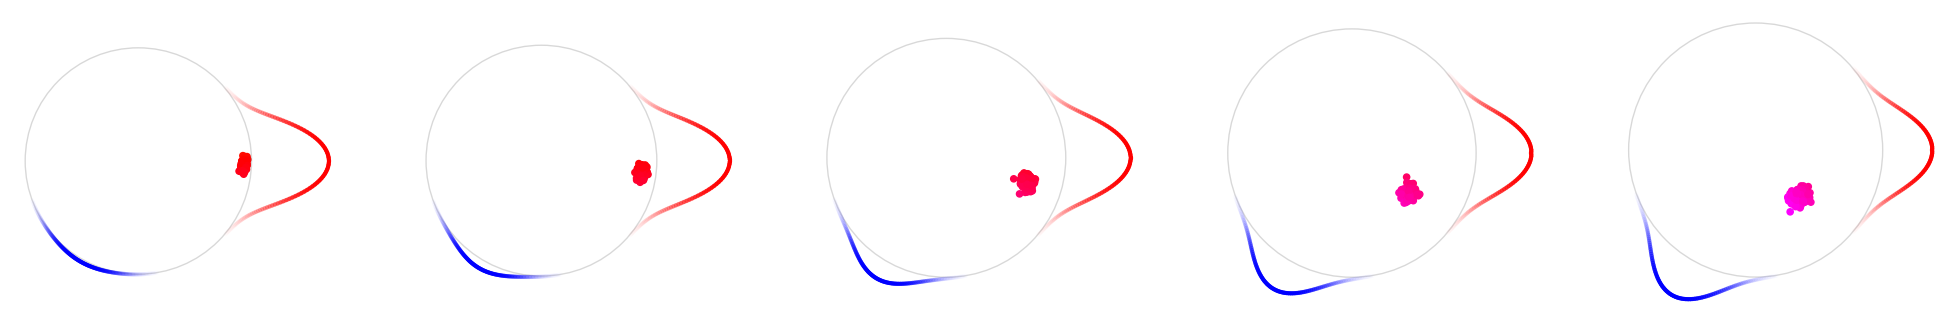

In [ ]:
from purias_utils.multiitem_working_memory.util.circle_utils import rot_to_rgb_torch
from scipy.stats import vonmises

figsize = 5

fig, axes = plt.subplots(1, 5, figsize = (5 * figsize, 1 * figsize), squeeze = True)

diffs = [torch.pi, 0.8 * torch.pi, 0.6 * torch.pi, 0.4 * torch.pi, 0.25 * torch.pi]


for ax, diff in zip(axes, diffs):

    swap_func: _T = -0.5 * (np.square(diff) / (task.task_variable_gen.swap_function_width + 2e-5))
    prob = np.exp(swap_func) / ((torch.e ** - task.task_variable_gen.swap_function_offset) + np.exp(swap_func))

    samples = generate_example_sample_sets(
        rnn = ddpm_model,
        task = task,
        distractor_probe = diff,
        distractor_report = - torch.pi * 2 / 3,
        generative_noise_factor = 1.0,
        num_samples = 128,
    )['samples']

    sample_colors = rot_to_rgb_torch(torch.arctan2(samples[0, :, 1], samples[0, :, 0]))
    sample_colors = [sc.tolist() for sc in sample_colors]
    ax.scatter(samples[0, :, 0], samples[0, :, 1], alpha=1.0, marker = 'o', s=20, c=sample_colors)
    ax.add_patch(plt.Circle((0, 0), task.sample_gen.sample_radius, color="gray", alpha = 0.3, fill=False))
    ax.set_aspect('equal')
    for spine in ax.spines.values():
        spine.set_visible(False)
    ax.tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)

    # # Draw the base circle in grey
    # ax.plot(
    #     center[0] + (radius + 0.1) * np.cos(theta),
    #     center[1] + (radius + 0.1) * np.sin(theta),
    #     color='gray', alpha=0.5, zorder=0, lw=4
    # )

    radius = task.sample_gen.sample_radius
    center = (0, 0)

    # Angles for plotting the mixture
    theta = np.linspace(-np.pi, np.pi, 500)  # More points for smoother arcs

    # Von Mises parameters
    kappa = 20  # concentration parameter, adjust for sharpness

    # Mode 1: rightmost point (0 radians), red
    mode1_mu = 0.0
    mode1_weight = 1 - prob
    mode1_pdf = mode1_weight * vonmises.pdf(theta, kappa, loc=mode1_mu)
    mode1_alpha = mode1_pdf / mode1_pdf.max()

    # Mode 2: -2pi/3 radians, blue
    mode2_mu = -2 * np.pi / 3
    mode2_weight = prob
    mode2_pdf = mode2_weight * vonmises.pdf(theta, kappa, loc=mode2_mu)
    mode2_alpha = mode2_pdf / mode2_pdf.max()

    # For each segment between points on the circle, plot a short colored arc with alpha blending
    for i in range(len(theta) - 1):
        for mode_pdf, color, mode_alpha in [
            (mode1_pdf, 'red', mode1_alpha),
            (mode2_pdf, 'blue', mode2_alpha)
        ]:
            seg_alpha = float((mode_alpha[i] + mode_alpha[i+1]) / 2)
            if seg_alpha > 0.01:  # Lower threshold for smoother fade
                arc_x = [
                    center[0] + (radius + mode_pdf[i]) * np.cos(theta[i]),
                    center[0] + (radius + mode_pdf[i+1]) * np.cos(theta[i+1])
                ]
                arc_y = [
                    center[1] + (radius + mode_pdf[i]) * np.sin(theta[i]),
                    center[1] + (radius + mode_pdf[i+1]) * np.sin(theta[i+1])
                ]
                ax.plot(
                    arc_x, arc_y,
                    color=color,
                    lw=3,
                    alpha=seg_alpha,
                    solid_capstyle='round'
                )

    # (Mixture plotting is now handled by the arc segment loop above for smoothness)

fig.savefig('neurips_figures/unimodal_control.svg', transparent = True)

In [15]:
prob

0.4487768327762736